<a href="https://colab.research.google.com/github/carbaluar/Presentaci-n/blob/main/CRR_impurezas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Carga de datos

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import sqlite3
import datetime

In [2]:
df = pd.read_excel('/content/DBImpurezas.xlsx')
df.head()

,SODIO,CALCIO,VANADIO,HIERRO,CRR,CRD,CRRbin
0,600,260,82,480,85.6581,3.5554,1
1,380,250,82,390,85.6581,3.5554,1
2,350,240,96,380,85.6581,3.5554,1
3,410,270,86,380,85.6581,3.5554,1
4,460,280,77,340,85.6581,3.5554,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3068 entries, 0 to 3067
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SODIO    3068 non-null   int64  
 1   CALCIO   3068 non-null   int64  
 2   VANADIO  3068 non-null   int64  
 3   HIERRO   3068 non-null   int64  
 4   CRR      3068 non-null   float64
 5   CRD      3068 non-null   float64
 6   CRRbin   3068 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 167.9 KB


In [4]:
from sklearn.model_selection import train_test_split

In [5]:
# divido entre train y test/validación en 70%/30%
df_train, df_test_validation = train_test_split(df, train_size=0.7, stratify = df["CRRbin"])

In [6]:

# divido entre train y test/validación en 15% y 15%
df_test, df_validation = train_test_split(df_test_validation, train_size=0.5, stratify = df_test_validation["CRRbin"])

In [7]:
df_train.shape

(2147, 7)

In [8]:
df_test.shape

(460, 7)

In [9]:
df_validation.shape

(461, 7)

### Modelo Gaussiano

In [10]:
from sklearn.naive_bayes import GaussianNB

In [11]:
clf = GaussianNB(priors=None, var_smoothing= 0.1)

In [12]:
df_train2 = df_train[["SODIO","CALCIO","VANADIO","HIERRO","CRRbin"]].copy()

In [13]:
clf.fit(df_train2.drop("CRRbin",axis=1), df_train2["CRRbin"])

GaussianNB(priors=None, var_smoothing=0.1)

In [14]:
clf.score(df_train2.drop("CRRbin",axis=1), df_train2["CRRbin"])

0.46204005589194225

In [15]:
df_validation2 = df_validation[["SODIO","CALCIO","VANADIO","HIERRO","CRRbin"]].copy()
df_test_validation2 = df_test_validation[["SODIO","CALCIO","VANADIO","HIERRO","CRRbin"]].copy()

In [16]:
clf.score(df_validation2.drop("CRRbin",axis=1), df_validation2["CRRbin"])


0.4511930585683297

In [17]:
BuscaSmoot = [0.1, 0.001, 0.0001, 0.00001, 0.000001, 0.000000000001]

In [18]:
scores = list()
for busca in BuscaSmoot:
    clf = GaussianNB(var_smoothing = busca)
    clf.fit(df_train2.drop("CRRbin",axis=1), df_train2["CRRbin"])
    scores.append(clf.score(df_validation2.drop("CRRbin",axis=1), df_validation2["CRRbin"]))

print("Máximo score con un smoothing de: ", BuscaSmoot[scores.index(max(scores))], "--> valor de Score: ", max(scores))

Máximo score con un smoothing de:  0.1 --> valor de Score:  0.4511930585683297


Dato Obtenido

In [19]:
from sklearn.metrics import confusion_matrix, roc_auc_score
import numpy as np
df_train2.head()

,SODIO,CALCIO,VANADIO,HIERRO,CRRbin
2990,349,180,110,230,0
59,460,210,79,320,0
526,269,196,85,401,1
1318,510,190,86,320,0
48,420,240,113,340,1


In [20]:
clf.predict(np.array([[400,300,200,100]]))

array([0])

Matriz

In [21]:
y_true = 1*np.array(df_validation2["CRRbin"])

In [22]:
y_pred = clf.predict_proba(df_validation2.drop("CRRbin",axis=1))

In [23]:
print("Matriz de Confusión Alfa 0.25")
print(confusion_matrix(y_true,y_pred[:,1]>0.25))

Matriz de Confusión Alfa 0.25
[[ 11 249]
 [  9 192]]


In [24]:
from sklearn.metrics import fbeta_score

In [25]:
print("Valor de F1 para un alfa= 0.25 -->", fbeta_score(y_true, y_pred[:,1]>0.25, beta=1))

Valor de F1 para un alfa= 0.25 --> 0.5981308411214953


In [26]:
print("Valor de Fbetascore para un alfa= 0.25 -->", fbeta_score(y_true, y_pred[:,1]>0.25, beta=2))

Valor de Fbetascore para un alfa= 0.25 --> 0.7710843373493975


In [27]:
alfa = 0.02
recalls = np.zeros(100)
precisions= np.zeros(100)
FPR = np.zeros(100)
alfas = np.linspace(0,1,100)
for idx,alfa in enumerate(alfas):
    tn, fp, fn, tp = confusion_matrix(y_true,y_pred[:,1]>alfa).ravel()
    recalls[idx] = (tp/(tp+fn))
    precisions[idx] = (tp/(tp+fp))
    FPR[idx]= (fp/(fp+tn))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


In [28]:
print("Para un alfa 0.25 --> Valor de recall", recalls[25], "Valor de Precisions", precisions[25], "Valor de FPR", FPR[25])
print("Para un alfa 0.5 --> Valor de recall", recalls[50], "Valor de Precisions", precisions[50], "Valor de FPR", FPR[50])
print("Para un alfa 0.75 --> Valor de recall", recalls[75], "Valor de Precisions", precisions[75], "Valor de FPR", FPR[75])

Para un alfa 0.25 --> Valor de recall 0.9552238805970149 Valor de Precisions 0.43537414965986393 Valor de FPR 0.9576923076923077
Para un alfa 0.5 --> Valor de recall 0.7860696517412935 Valor de Precisions 0.42133333333333334 Valor de FPR 0.8346153846153846
Para un alfa 0.75 --> Valor de recall 0.029850746268656716 Valor de Precisions 0.5454545454545454 Valor de FPR 0.019230769230769232


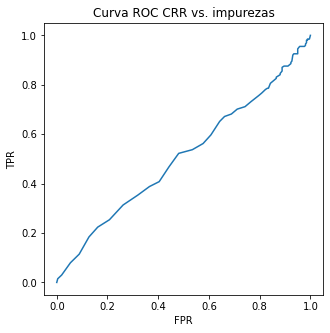

In [29]:
plt.figure(figsize=[5,5])
plt.plot(FPR,recalls)
plt.title("Curva ROC CRR vs. impurezas")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()